In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from stock_data import StockData
import datetime
from hmmlearn import hmm
from matplotlib.dates import YearLocator, MonthLocator


ticker = 'AAPL'
today = datetime.date.today()
past = datetime.date(2023, 1, 2)
data_interval = '1d'

stock = StockData(ticker, past, today, data_interval)
data = stock.history

data['Date'] = stock.history.index.values

stock.candlestick

In [ ]:
returns_ratio = np.divide(data["Close"].shift(1).values.tolist(),data["Close"].values.tolist())
log_returns = np.log(returns_ratio)
log_returns_df = pd.DataFrame(log_returns).set_index(data.index).dropna()
X = log_returns_df.values.reshape(-1, 1)


best_score = None
try_components = [2, 3, 4, 5]

for n in try_components:
    for i in range(10):
        try_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
        try_model.fit(X)
        score = try_model.aic(X)
        if best_score is None or score < best_score:
            best_score = score
            model = try_model
        #print("{} Components on Iteration {}, AIC: {}".format(n, i+1, score))

Model is not converging.  Current: 507.0551274876463 is not greater than 507.09054537539345. Delta is -0.03541788774714405
Model is not converging.  Current: 507.07865134972707 is not greater than 507.15469764048254. Delta is -0.07604629075547109
Model is not converging.  Current: 500.6101961788101 is not greater than 500.6120163394099. Delta is -0.0018201605997774095
Model is not converging.  Current: 506.6984148765119 is not greater than 506.77006204341154. Delta is -0.07164716689965189
Model is not converging.  Current: 507.03134177340706 is not greater than 507.0781490481803. Delta is -0.046807274773243535
Model is not converging.  Current: 507.06804573721814 is not greater than 507.09474759816516. Delta is -0.02670186094701421
Model is not converging.  Current: 507.04663735163695 is not greater than 507.0777797913363. Delta is -0.0311424396993516
Model is not converging.  Current: 506.7098509000807 is not greater than 506.76961805137256. Delta is -0.05976715129185095
Model is not 

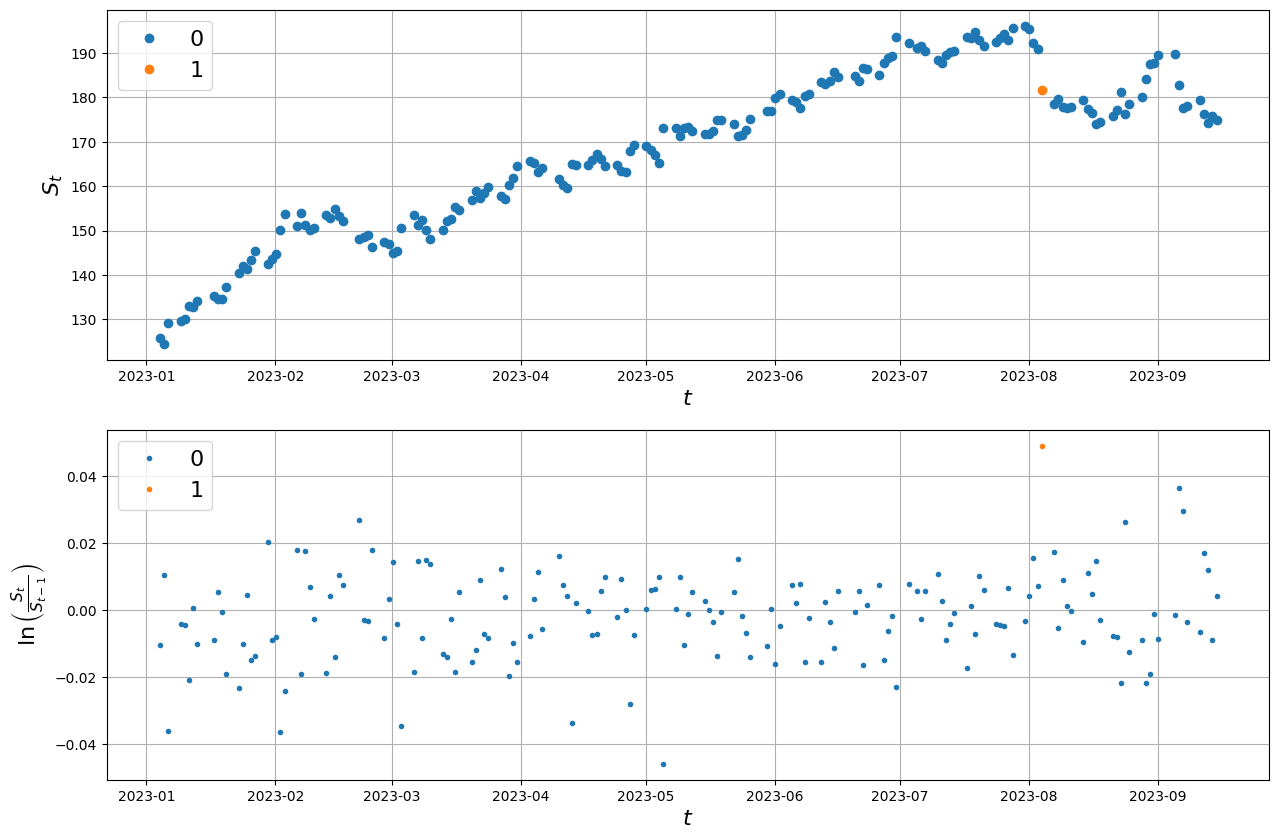

In [ ]:
Z=model.predict(X)
states=pd.unique(Z)

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    y = data["Close"].tail(-1).iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.', linewidth=2, markersize=12)
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$S_t$', fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    y = log_returns_df.iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\ln\left(\frac{S_t}{S_{t-1}}\right)$', fontsize=16)
plt.show()

In [ ]:
for state in range(len(states)):
    print("State {}: Mean = {}".format(state, model.means_[state][0]))

State 0: Mean = -0.0020742019252874577
State 1: Mean = 0.004525293022876533


In [1]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

#t = yf.download(stocks, start=start, end = end, interval='1d')
ret = 100*(yf.download(ticker, start=past, end=today, interval=data_interval).pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

W = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
W = W[4:].copy()
W = W.reset_index()
W.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)
realized_vol.index = ret.iloc[4:].index

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

n=50
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
            'max_iter': [500, 1000],
            'alpha': [0.00005, 0.0005]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(W.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))

NN_predictions = clf.predict(W.iloc[-n:])

NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                    NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()